## Notebook to reproduce results from Pistachio BERT

In [7]:
# To reproduce Pistahcio BERT results in notebook use environment defined in https://github.com/rxn4chemistry/rxnfp

import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os  
import json
import sys
from rdkit.Chem import MolFromSmiles, MolToSmiles

from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

import torch
import pkg_resources
import pandas as pd
import math

from rxnfp.models import SmilesClassificationModel

from tqdm.notebook import tqdm
tqdm.pandas()

def get_folder_names(dir_name, num):
    folder_names = {}
    epoch_list = [i for i in range(1,num)]
    for folder in os.listdir(dir_name):
        try:
            if int(folder.split("-")[-1]) in epoch_list:
                folder_names[int(folder.split("-")[-1])] = folder
        except:
            pass
    return folder_names

def smi_tokenizer(smi):
    """
    Tokenize a SMILES molecule or reaction
    """
    import re
    pattern =  "(\%\([0-9]{3}\)|\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\||\(|\)|\.|\^|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])" #=O?|
    regex = re.compile(pattern)
    tokens = [token for token in regex.findall(smi)]
    assert smi == ''.join(tokens)
    return ' '.join(tokens)

def split_data(df, n):
    """
    Partitions a dataframe into n equal sized blocks, outputs a list with respective blocks
    """
    block_size = math.ceil(len(df)/n)
    return [df.iloc[i:i + block_size] for i in range(0, len(df), block_size)]


def convert_stringlist2listfloat(stringlist):
    """
    Function to use when after loading a list in a dataframe ast.literal_eval() is not capable of processing syntax of recorded list
    """
    equivalents_float = []
    equivalents_str2list = stringlist.split(",")
    try:
        for i, element in enumerate(equivalents_str2list):
            if i == 0 and element[1:] == "nan":
                equivalents_float.append(-10)
            elif i == 0 and element[1:] != "nan":
                equivalents_float.append(float(element[1:]))
            elif i == len(equivalents_str2list)-1 and element[1:] == "nan]":
                equivalents_float.append(-10)
            elif i == len(equivalents_str2list)-1 and element[1:] != "nan]":
                equivalents_float.append(float(element[1:-1]))
            elif element[1:] == "nan":
                equivalents_float.append(-10)
            elif element[1:] != "nan":
                equivalents_float.append(float(element[1:]))
    except:
        equivalents_float = np.nan
    return equivalents_float 

def add_photocat_react_ids(row):
    reactant_ids_order_size = len(row.reactant_ids_order)
    reactant_ids_order = row.reactant_ids_order
    if 3 not in row.reactant_ids_order:
        for i in range(row.reaction_smiles_std.count(".")+1- reactant_ids_order_size):
            reactant_ids_order.append(3+i*0.1)
    return reactant_ids_order


def replace_sep(row):
    """
    Replace token . used to indicate an ionic bond by ^ to differentiate from the token . used to separate molecules
    """
    separators = []
    ordered_reactant_ids = row["reactant_ids_order"]
    for i in range(len(ordered_reactant_ids)-1):
        if int(ordered_reactant_ids[i]) == int(ordered_reactant_ids[i+1]):
            separators.append("^")
        else:
            separators.append(".")
        
    smiles_sep = [row["reaction_smiles_std"].split(".")[0]]
    for mol, sep in zip(row["reaction_smiles_std"].split(".")[1:], separators):
        smiles_sep.append(sep)
        smiles_sep.append(mol)       
        
    return ''.join(smiles_sep)

def combine_smilessep_uniqprod(row):
    return row.smiles_sep.split(">>")[0]+">>"+row.reaction_smiles.split(">>")[1]

def add_photocat_react_ids(row):
    reactant_ids_order_size = len(row.reactant_ids_order)
    reactant_ids_order = row.reactant_ids_order
    if 3 not in row.reactant_ids_order:
        for i in range(row.reaction_smiles_std.count(".")+1- reactant_ids_order_size):
            reactant_ids_order.append(3+i*0.1)
    return reactant_ids_order

def sort_reactants(lista):
  
    list_size=[]   
    for ele in lista:
         list_size.append(len(ele))     
    sortedindex = np.argsort(list_size)  
    listb = [" " for i in range(len(lista))]  
    
    for i in range(len(lista)):    
        listb[i] = lista[sortedindex[i]]     
                                          
    return listb

def add_canonical_rxn_smiles(df_photoredox_merck):

    #Get Canonical SMILES with rdkit
    reactions_standardized = []

    for rxn_separated in df_photoredox_merck["reaction_smiles_sep"].values:
        rxn_separated = rxn_separated.replace(".","|")
        rxn_separated = rxn_separated.replace("^",".")
        reactants = rxn_separated.split(">>")[0]
        products = rxn_separated.split(">>")[1]
        reactants_canonical = []
        products_canonical = []

        try:
            for reactant in reactants.split("|"):
                reactants_canonical.append(MolToSmiles(MolFromSmiles(reactant)))

            reactants_canonical_sorted = sort_reactants(reactants_canonical)
            reactants_canonical_sorted = ".".join(reactants_canonical_sorted)

            products_canonical = MolToSmiles(MolFromSmiles(products))

            rxn_stdd = reactants_canonical_sorted + ">>" + products_canonical
        except:
            rxn_stdd = "invalid_structure"

        reactions_standardized.append(rxn_stdd)

    df_photoredox_merck["rxns_canonical_rdkit"] = reactions_standardized
    
    return df_photoredox_merck


def epochs_calc_r2(df_test, model_dir, checkpoit_multiple=22, epoch_offset = 0, final_epoch = 200, stride = 10):
    r2_scores = []
    epochs = []
    for i in range(epoch_offset, final_epoch+stride, stride):
        model_path = model_dir + f"/checkpoint-{i*checkpoit_multiple}-epoch-{i}"
        trained_yield_bert = SmilesClassificationModel('bert', model_path, num_labels=1, args={"regression": True}, use_cuda=torch.cuda.is_available())
        if "equivalents" in df_test.columns:
            print("Equivalents used.")
            lcms_predicted = trained_yield_bert.predict(df_test.text.values, equivalents = df_test.equivalents.values)[0]
        else:
            lcms_predicted = trained_yield_bert.predict(df_test.text.values)[0]

        lcms_true = df_test.labels.values
        epochs.append(f"epoch_{i}")
        r2_scores.append(r2_score(lcms_true, lcms_predicted))
    r2_scores = {k:v for k,v in zip(epochs, r2_scores)}
    return r2_scores


def inference_record_performance(file_name, col_input, epoch_offset = 20, final_epoch = 340, stride = 20, split_num = 5):

    r2_scores_all = {}
    max_r2_scores_all = {}
    for i in range(split_num):
        photoredox_merck_5_splitted = split_data(df_photoredox_merck, math.ceil(len(df_photoredox_merck)/split_num))
        val_test = photoredox_merck_5_splitted.pop(i)
        test = val_test.iloc[:int(len(val_test)/2)]

        model_dir = f"../results/{base_model}_{file_name}_ncv_{i}"
        r2_scores = epochs_calc_r2(test[col_input], model_dir, checkpoit_multiple=22, epoch_offset = epoch_offset, final_epoch = final_epoch, stride = stride)
        r2_scores_all[f"ncv_{i}"] = r2_scores
        max_r2_scores_all[f"ncv_{i}"] = max(moving_avg(list(r2_scores.values()), sig_range = 3))

    data = [max_r2_scores_all, r2_scores_all]
    data_json = json.dumps(data, indent=2)

    with open(f"../results/{base_model}_{file_name}_ncv_results.json", "w") as outfile:
        outfile.write(data_json)
    
    print(f"Finished generating and saving JSON result files to /results/{base_model}_{file_name}_ncv_results.json")
    
def train_save(df_photoredox, split_num, model_path, file_name, model_args, col_input):
    
    for i in range(split_num):
        photoredox_splits = split_data(df_photoredox, math.ceil(len(df_photoredox)/split_num))
        val_test = photoredox_splits.pop(i)
        train = pd.concat(photoredox_splits)
        val = val_test.iloc[int(len(val_test)/2):]
        test = val_test.iloc[:int(len(val_test)/2)]

        output_dir = f"fine_tuned_models/{base_model}_{file_name}_ncv_{i}"

        pretrained_bert = SmilesClassificationModel("bert", model_path, num_labels=1, args=model_args, use_cuda=torch.cuda.is_available())
        pretrained_bert.train_model(train[col_input], output_dir=output_dir, show_running_loss=False, eval_df=val[col_input])
        
    print(f"Finished training and saving models to fine_tuned_models/{base_model}_{file_name}_ncv")
    
    
def load_prepare_data(data_path):
    """
    Load .csv into dataframe and process data into ML ready format
    """
    df_photoredox = pd.read_csv(data_path + "/Photoredox_rxns.csv", index_col = 0)
    
    #Adding a high moles value to solvent which makes it so resulting class wont overlap with other enrichment embedding classes 
    df_photoredox["solvent_moles"] = 1000

    #notebook expects data to be standardized (rdkit canonical sorted) with reactant_ids ready
    df_photoredox["reactant_ids_order"] = df_photoredox.progress_apply(lambda row: convert_stringlist2listfloat(row["reactant_ids_order"]), axis = 1)
    df_photoredox["reactant_ids_order"] = df_photoredox.progress_apply(lambda row: add_photocat_react_ids(row), axis = 1)
    df_photoredox["reactant_moles"] = df_photoredox.progress_apply(lambda row: convert_reactant_id_2_moles(row), axis = 1)

    df_photoredox["enrichment_class"] = df_photoredox.reactant_moles.progress_apply(lambda reactant_moles: CondIDEnc.convert_conditions2class(reactant_moles))

    df_photoredox["reaction_smiles_sep"] = df_photoredox.apply(lambda row: replace_sep(row), axis = 1)
    df_photoredox["equivalents"] = df_photoredox.progress_apply(lambda row: CondIDEnc.generate_equivalents_vector(row), axis = 1)
    df_photoredox["equivalents_vector_size"] = df_photoredox.equivalents.apply(lambda eqvs_vec: len(eqvs_vec))

    #sanity check
    df_photoredox["reaction_smiles_size"] = df_photoredox["reaction_smiles_std"].apply(lambda react_smiles: len(smi_tokenizer(react_smiles).split(" ")))
    assert df_photoredox['reaction_smiles_size'].equals(df_photoredox['equivalents_vector_size'])
    
    df_photoredox["labels"] = df_photoredox['uplcms'].apply(lambda uplcms: uplcms/100)
    df_photoredox = add_canonical_rxn_smiles(df_photoredox)
    df_photoredox.rename(columns={"rxns_canonical_rdkit":"text"}, inplace = True)
    df_photoredox = df_photoredox.sample(frac = 1, random_state = 42)

    return df_photoredox

In [ ]:
def get_enrichment_size(model_name):
    config_path = f'../reaction_transformers/pretrained_models/transformers/bert_{model_name}/config.json'
    with open(config_path) as f:
        config = json.load(f)
        return config['equivalents_vocab_size']

class ConditionIDEncoder():
    def __init__(self, model_name, thresholds, id2role):
        
        self.model_name = model_name
        self.thresholds = thresholds
        self.id2role = id2role
        self.enriched_emb_vocab_size =  get_enrichment_size(model_name)
        self.config_path = f'../reaction_transformers/pretrained_models/transformers/bert_{model_name}/config.json'
        
        assert len(thresholds) < self.enriched_emb_vocab_size-5 , \
        f"The enrichment embedding size ({get_enrichment_size(model_name)}) is not large enough for the total number of ID classes ({len(thresholds)+5}). \
        Reduce the number of thresholds or train a precursor model set to have a larger enrichment vocab size."
        
    def convert_conditions2class(self, condition_data):
        """
        Convert numerical/categorical condition data into enrichment class ids using user defined thresholds
        """
        enrich_classes = np.digitize(condition_data, self.thresholds)
        return list(map(lambda x:x+2, enrich_classes))
    
    def generate_equivalents_vector(self, row):
        """
        Generate a vector of categorical enrichment class ids with as many elements as the numbers of tokens in the reaction
        """
        reaction = row.reaction_smiles_sep
        enrichment_class = row.enrichment_class
        enrich_class_count = 0
        equivalents_vector = []
        for token in smi_tokenizer(reaction).split(" "):
            if token != " ":
                if token == ">>":
                    equivalents_vector.append(self.enriched_emb_vocab_size-3)
                    enrich_class_count = "product"
                else:
                    if enrich_class_count == "product":
                        equivalents_vector.append(self.enriched_emb_vocab_size-2)
                    else:
                        if token == "." or token == "^":
                            if token == ".":
                                equivalents_vector.append(self.enriched_emb_vocab_size-1)
                            if token == "^":
                                equivalents_vector.append(enrichment_class[enrich_class_count])
                            enrich_class_count += 1
                        else:
                            equivalents_vector.append(enrichment_class[enrich_class_count])
        return equivalents_vector
    
    def convert_reactant_id_2_moles(self, row):
        """
        Convert reactant ids (not the enriched embedding ids) to their respective moles quantity for a particular reaction
        """
        return [row[self.id2role[str(math.floor(r_id))+"_moles"]] for r_id in row.reactant_ids_order]

In [146]:
df_photoredox = load_prepare_data(data_path = '../data')

base_model = "pretrained"
model_path = pkg_resources.resource_filename("rxnfp", f"models/transformers/bert_{base_model}")
file_name = "photoredox_1700"
split_num = 5
dropout = 0.75
l_r = 0.00001
model_args = { 'num_train_epochs': 100, 'overwrite_output_dir': True, #"save_epochs": 20,
                'learning_rate': l_r, 'gradient_accumulation_steps': 1,
                'regression': True, "num_labels":1, "fp16": False,
                "evaluate_during_training": True, 'manual_seed': 42,
                "max_seq_length": 350, "train_batch_size": 64,"warmup_ratio": 0.00,
                "config" : {'hidden_dropout_prob': dropout}}
col_input = ["text","labels"]

train_save(df_photoredox, split_num, model_path, file_name, model_args, col_input)

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/1382 [00:00<?, ?it/s]

Epoch:   0%|          | 0/340 [00:00<?, ?it/s]

/home/pneves6/.conda/envs/yields/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
/home/pneves6/.conda/envs/yields/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/1382 [00:00<?, ?it/s]

Epoch:   0%|          | 0/340 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/1382 [00:00<?, ?it/s]

Epoch:   0%|          | 0/340 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/1382 [00:00<?, ?it/s]

Epoch:   0%|          | 0/340 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/1384 [00:00<?, ?it/s]

Epoch:   0%|          | 0/340 [00:00<?, ?it/s]

In [ ]:
file_name = "photoredox_1700_start"
model_args = { 'num_train_epochs': 18, 'overwrite_output_dir': True, #"save_epochs": 2,
                'learning_rate': l_r, 'gradient_accumulation_steps': 1,
                'regression': True, "num_labels":1, "fp16": False,
                "evaluate_during_training": True, 'manual_seed': 42,
                "max_seq_length": 350, "train_batch_size": 64,"warmup_ratio": 0.00,
                "config" : {'hidden_dropout_prob': dropout}}

train_save(df_photoredox, split_num, model_path, file_name, model_args, col_input)

In [ ]:
df_photoredox_merck = load_prepare_data(data_path = '../data)
file_name = "photoredox_1700"
epoch_offset = 20; final_epoch = 120; stride = 20, split_num = 5                                        
inference_record_performance(file_name, col_input, epoch_offset, final_epoch, stride)

In [ ]:
#df_photoredox_merck = load_prepare_data(data_path = '../data)
file_name = "photoredox_1700_start"
epoch_offset = 0; final_epoch = 18; stride = 2, split_num = 5                                        
inference_record_performance(file_name, col_input, epoch_offset, final_epoch, stride)

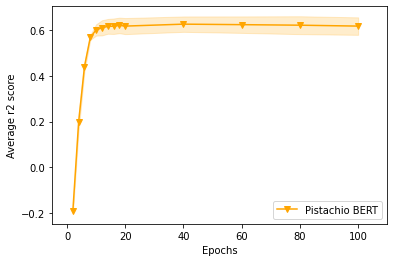

In [20]:
with open (f"results/pretrained_photoredox_1700_ncv_start_results.json", "r") as json_data:
    r2_scores_start_all = json.loads(json_data.read())

with open (f"results/pretrained_photoredox_1700_ncv_results.json", "r") as json_data:
    r2_scores_all = json.loads(json_data.read())

r2_start_all_avg, r2_start_all_min, r2_start_all_max, r2_start_all_std = r2score_stats(r2_scores_start_all[1])    
r2_all_avg, r2_all_min, r2_all_max, r2_all_std = r2score_stats(r2_scores_all[1])

r2_all_avg = r2_start_all_avg+r2_all_avg; r2_all_min = r2_start_all_min+r2_all_min; r2_all_max = r2_start_all_max+r2_all_max;r2_all_std = r2_start_all_std + r2_all_std

epochs_start = [int(ep.split("_")[1]) for ep in list(r2_scores_start_all[1]["ncv_0"].keys())]
epochs = [int(ep.split("_")[1]) for ep in list(r2_scores_all[1]["ncv_0"].keys())]
epochs = epochs_start+epochs

plt.plot(epochs[:14], r2_all_avg[:14], marker='v', color='orange', label = "Pistachio BERT")
plt.fill_between(epochs[:14], [i-j for i,j in zip(r2_all_avg[:14], r2_all_std[:14])], [i+j for i,j in zip(r2_all_avg[:14],r2_all_std[:14])], color='orange', alpha=0.2)
plt.xlim(-5,110)
plt.xlabel("Epochs")
plt.ylabel("Average r2 score")
plt.legend(loc = 'lower right')
plt.show()